# Testing rotation period optimisation.

The purpose of this project is to attempt to optimise the measurement of stellar rotation periods from TESS data. This will involve the following stages:

1) Calculate single & double Lomb-Scargle periodograms, ACFs and PDMs of Kepler light curves with and without measured rotation periods (McQuillan et al. 2014).

2) Calculate features/statistics of these: heights and positions of tallest peaks, etc.

3) Train a random forest classifier to classify rotators, non-rotators, and non-periodic rotators.

4) Train a random forest regressor to measure a rotation period from these features.

5) Repeat with Kepler light curves cut into 27 days sectors.

6) Build a training set from TESS CVZ stars.

7) Repeat using this as a training set.

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import starrotate as sr
import kepler_data as kd
import sigma_clip as sc
import calc_statistics as cs

First let's just try one star. Load the McQuillan tables.

In [3]:
mc1 = pd.read_csv("../data/Table_1_Periodic.txt")
mc2 = pd.read_csv("../data/Table_2_Non_Periodic.txt")

mc1.head()

,kepid,Teff,logg,Mass,Prot,Prot_err,Rper,LPH,w,DC,Flag
0,892376,3813,4.47,0.4699,1.532,0.007,7306.69,0.823,0.4503,0,---
1,1026146,4261,4.57,0.6472,14.891,0.120,11742.56,1.405,0.7229,0,---
2,1026474,4122,4.56,0.5914,1.569,0.006,30471.80,1.204,0.6061,0,---
3,1162635,3760,4.77,0.4497,15.678,0.019,10207.47,0.978,0.5445,1,---
4,1164102,4045,4.62,0.5606,31.496,0.474,5139.74,0.568,0.3939,0,---


Load the first light curve.

In [4]:
# def load_and_process(i):
    
#     # Load the light curve
#     kplr_path = "/Users/rangus/.kplr/data/lightcurves"
#     x, y, yerr = kd.load_and_split(os.path.join(kplr_path, str(int(mc1.iloc[i].kepid)).zfill(9)))

#     # Sigma clip in each quarter
#     clipped_x, clipped_y, clipped_yerr = [], [], []
#     for i in range(len(x)):
#         _, mask = sc.sigma_clip(y[i], nsigma=4)
#         clipped_x.append(x[i][mask])
#         clipped_y.append(y[i][mask])
#         clipped_yerr.append(yerr[i][mask])
#     x = np.array([i for j in clipped_x for i in j])
#     y = np.array([i for j in clipped_y for i in j])
#     yerr = np.array([i for j in clipped_yerr for i in j]) 

#     # Sort arrays
#     inds = np.argsort(x)
#     x, y, yerr = x[inds], y[inds], yerr[inds]

#     # Start at zero
#     x -= x[0]
    
#     return x, y, yerr

i = 0
kplr_path = "/Users/rangus/.kplr/data/lightcurves"
path_to_light_curve = os.path.join(kplr_path, str(int(mc1.iloc[i].kepid)).zfill(9))
x, y, yerr = cs.load_and_process(path_to_light_curve)

In [5]:
rm = sr.RotationModel(x, y, yerr)

Calculate LS periodogram and ACF.

In [6]:
highest_peak_period = rm.LS_rotation()
highest_peak_acf = rm.ACF_rotation(interval=0.02043365)

/Users/rangus/projects/starrotate/starrotate/rotation_tools.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real


Calculate some statistics. Ideas:

Lomb-Scargle:

1st 3 Peak positions, 1st 3 Peak heights, RMS, MAD

ACF

1st 3 Peak positions, 1st 3 Peak heights, Highest 3 Peak positions, Highest 3 Peak heights

Light curve:

Rvar, Rvar_10day, Rvar_20day, Rvar_50_day

Define a function for calculating peak statistics.

In [7]:
# def get_peak_statistics(x, y):
    
#     # Array of peak indices
#     peaks = np.array([i for i in range(1, len(y)-1) if y[i-1] < 
#                       y[i] and y[i+1] < y[i]])
    
#     # extract peak values
#     x_peaks = x[peaks]
#     y_peaks = y[peaks]
    
#     # sort by height
#     inds = np.argsort(y_peaks)
#     x_peaks1, y_peaks1 = x_peaks[inds][::-1], y_peaks[inds][::-1]
    
#     # sort by position
#     inds2 = np.argsort(x_peaks)
#     x_peaks2, y_peaks2 = x_peaks[inds2], y_peaks[inds2]
    
#     return x_peaks1, y_peaks1, x_peaks2, y_peaks2

Get statistics.

In [8]:
# from astropy.timeseries import LombScargle

# def get_statistics(ps, power, lags, acf):
    
#     # Highest 3 peak heights and positions in the LS periodogram
#     peak_periods1, peak_powers1, _, _ = get_peak_statistics(ps, power)
#     ls_mad = np.median(np.abs(rm.power))
#     ls_rms = np.sqrt(np.mean(rm.power**2))

#     # Highest and first 3 peak heights and positions in the LS periodogram
#     lags1, acf1, lags2, acf2 = get_peak_statistics(lags, acf)

#     # Calculate periodogram of ACF
#     acf_freqs = np.linspace(1./100, 1./.1, 10000)
#     acf_pgram = LombScargle(lags, acf).power(acf_freqs)
#     acf_ls_periods, acf_ls_powers, _, _ = get_peak_statistics(1./acf_freqs, acf_pgram)
#     acf_ls_h3, acf_ls_p3 = acf_ls_powers[:3], acf_ls_periods[:3]

#     acf_mad = np.median(np.abs(acf))
#     acf_rms = np.sqrt(np.mean(acf**2))

#     Rvar = np.percentile(y, 95) - np.percentile(y, 5)
#     Rvar
    
#     # highest 3 pgram heights, highest 3 pgram periods, highest 3 ACF heights, highest 3 ACF periods,
#     # 1st 3 ACF heights, 1st 3 ACF periods, highest 3 acf_pgram heights, highest 3 acf_pgram periods,
#     # ls_mad, ls_rms, acf_mad, acf_rms, Rvar
#     return peak_powers1[:3], peak_periods1[:3], acf1[:3], lags1[:3], acf2[:3], lags2[:3], \
#         acf_ls_powers[:3], acf_ls_periods[:3], ls_mad, ls_rms, acf_mad, acf_rms, Rvar, \
#         acf_freqs, acf_pgram

ls_h, ls_p, acf_h1, acf_p1, acf_h2, acf_p2, acf_pgram_h, acf_pgram_p, ls_mad, ls_rms, \
    acf_mad, acf_rms, Rvar, acf_freqs, acf_pgram = cs.get_statistics(
    y, 1./rm.freq, rm.power, rm.lags, rm.acf)

NameError: name 'y' is not defined

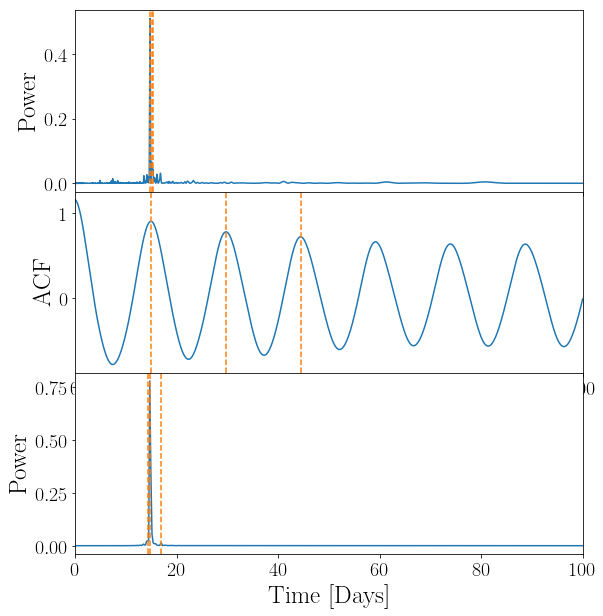

In [344]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(311)
ax1.plot(1./rm.freq, rm.power)
ax1.set_xlim(0, np.min([10*highest_peak_period, max(1./rm.freq)]))
ax1.set_ylabel("$\mathrm{Power}$")
ax1.axvline(ls_p[0], color="C1", ls="--")
ax1.axvline(ls_p[1], color="C1", ls="--")
ax1.axvline(ls_p[2], color="C1", ls="--")

ax2 = fig.add_subplot(312, sharex=ax1)
ax2.plot(rm.lags, rm.acf)
ax2.set_ylabel("$\mathrm{ACF}$")
ax2.axvline(acf_p2[0], color="C1", ls="--")
ax2.axvline(acf_p2[1], color="C1", ls="--")
ax2.axvline(acf_p2[2], color="C1", ls="--")

ax3 = fig.add_subplot(313, sharex=ax1)
ax3.plot(1./acf_freqs, acf_pgram)
ax3.axvline(acf_pgram_p[0], color="C1", ls="--")
ax3.axvline(acf_pgram_p[1], color="C1", ls="--")
ax3.axvline(acf_pgram_p[2], color="C1", ls="--")
ax3.set_ylabel("$\mathrm{Power}$")
ax3.set_xlabel("$\mathrm{Time~[Days]}$")

plt.subplots_adjust(hspace=0, right=0.83)
plt.setp(ax1.get_xticklabels(), visible=False);

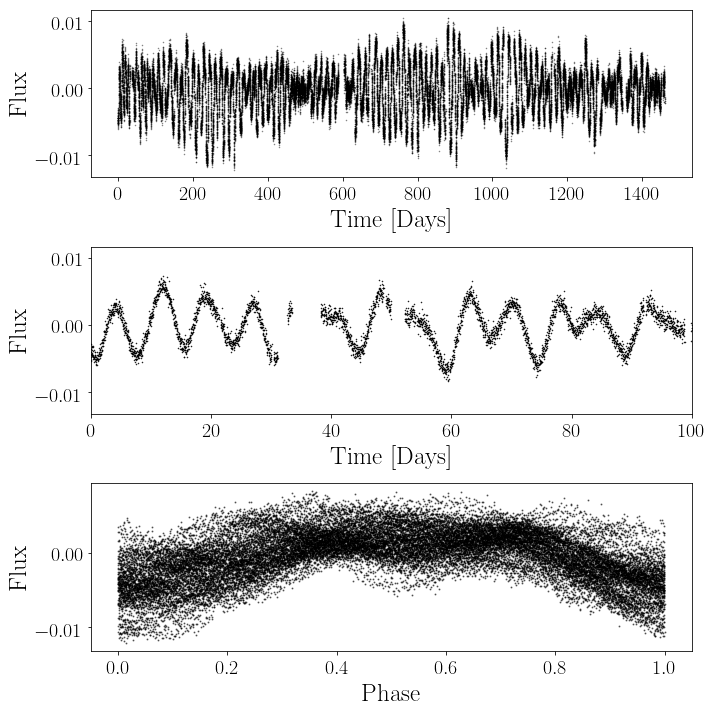

In [345]:
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(311)
ax1.plot(x, y, "k.", ms=1, alpha=.5)
ax1.set_ylabel("$\mathrm{Flux}$")
ax1.set_xlabel("$\mathrm{Time~[Days]}$")

ax2 = fig.add_subplot(312)
ax2.plot(x, y, "k.", ms=1)
ax2.set_xlim(x[0], x[0]+100)
ax2.set_ylabel("$\mathrm{Flux}$")
ax2.set_xlabel("$\mathrm{Time~[Days]}$")

ax3 = fig.add_subplot(313)
phase = (x % ls_p[0])/ls_p[0]
m = x < 50*ls_p[0]
ax3.plot(phase[m], y[m], "k.", ms=2, alpha=.5)
ax3.set_ylabel("$\mathrm{Flux}$")
ax3.set_xlabel("$\mathrm{Phase}$")
plt.tight_layout()

In [338]:
print(ls_p[0], acf_p2[0], acf_pgram_p[0], mc1.iloc[i].Prot)

1.5335924517051571 1.49165645 1.5327520556260694 1.569
